=== Overall Summary (err_mean) ===


,Metric,Pre_trained,Ori
0,Mean,7.348015,5.326926
1,Median,3.965000,3.520000
2,Std,17.495943,6.899044
3,Count,1506.000000,1506.000000


=== Stress-hold ( <50% | 50% | >50% ) ===


,OverlapZone,MeanError_Pre_trained,StdError_Pre_trained,MeanError_Ori,StdError_Ori,Count,Improvement_% (Ori vs Pre_trained)
0,< 50%,198.048571,87.824635,42.612857,49.218017,7,78.483633
1,> 50%,6.457485,10.291412,5.152809,5.620484,1499,20.204096


=== Per 10% Overlap Bin Summary ===


,OverlapBin,MeanError_Pre_trained,StdError_Pre_trained,MeanError_Ori,StdError_Ori,Count,Improvement_% (Ori vs Pre_trained)
0,30-40%,211.490000,19.063599,73.400000,78.531279,2,65.293867
1,40-50%,192.672000,106.547756,30.298000,37.793327,5,84.274830
2,50-60%,86.322500,53.610197,15.562500,1.124259,4,81.971676
3,60-70%,71.693333,26.905289,29.246667,21.792609,6,59.205877
4,70-80%,107.323333,35.610735,22.673333,13.826338,3,78.873808
5,80-90%,46.692000,27.761583,31.897000,25.540859,10,31.686370
6,90-100%,5.498259,5.064177,4.809851,4.240745,1476,12.520470


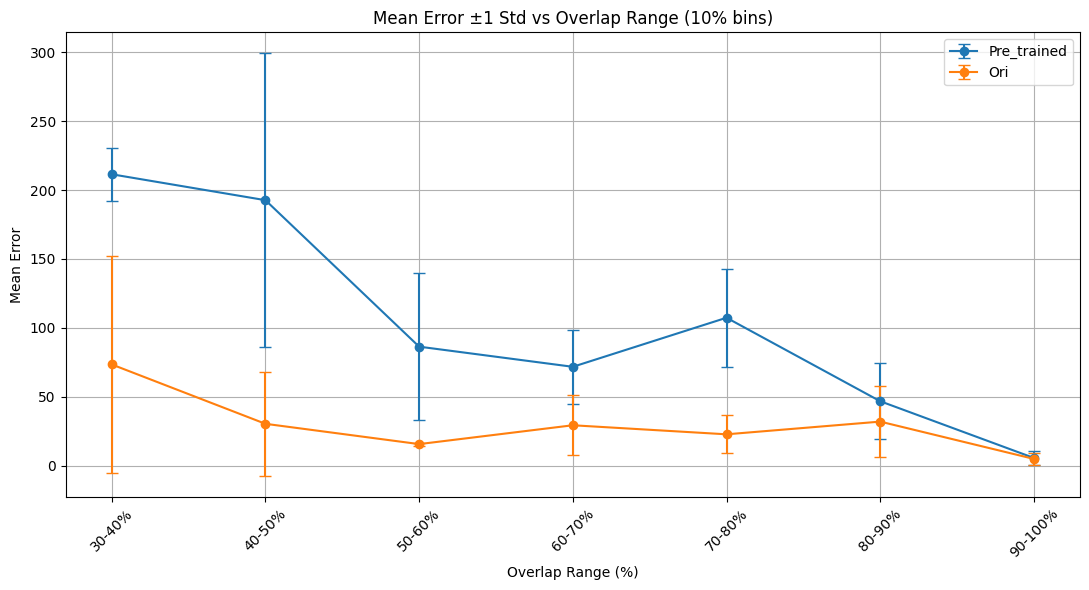

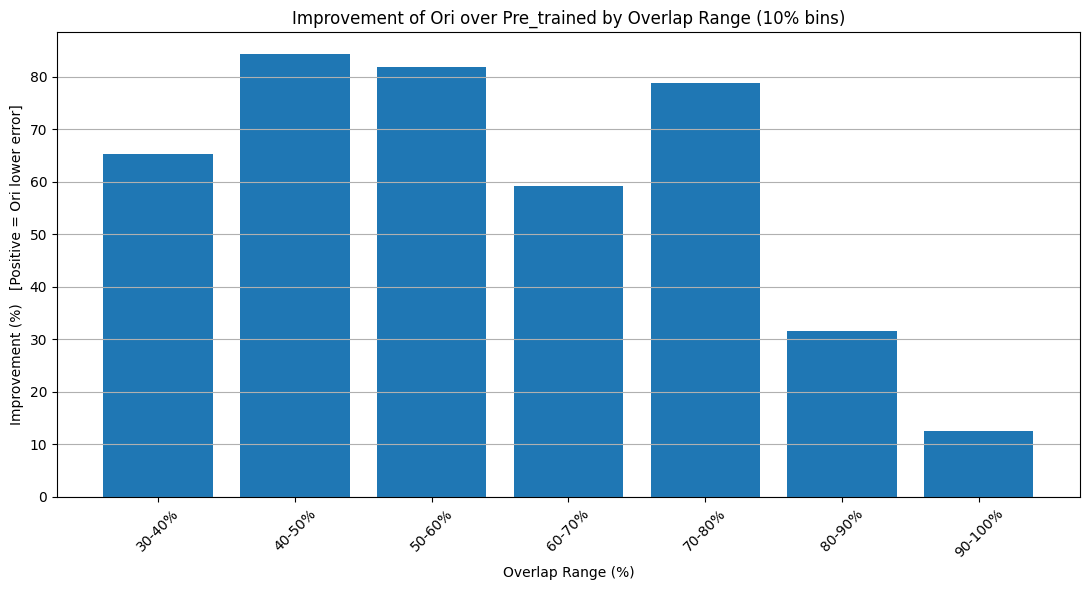

/tmp/ipykernel_15269/1594585607.py:192: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df[err_Pre_trained].dropna().values, df[err_Ori].dropna().values], labels=["Pre_trained", "Ori"])


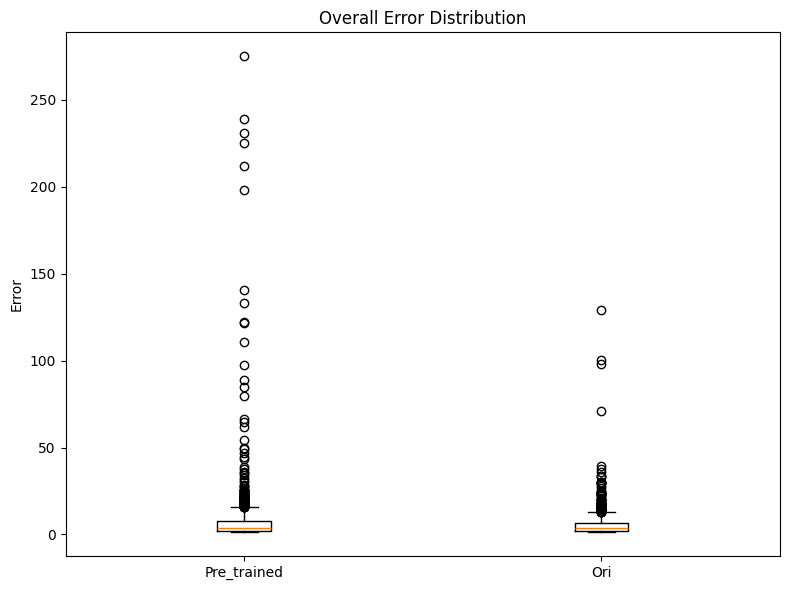

/tmp/ipykernel_15269/1594585607.py:204: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df.loc[low_mask, err_Pre_trained].dropna().values, df.loc[low_mask, err_Ori].dropna().values], labels=["Pre_trained (≤50%)", "Ori (≤50%)"])


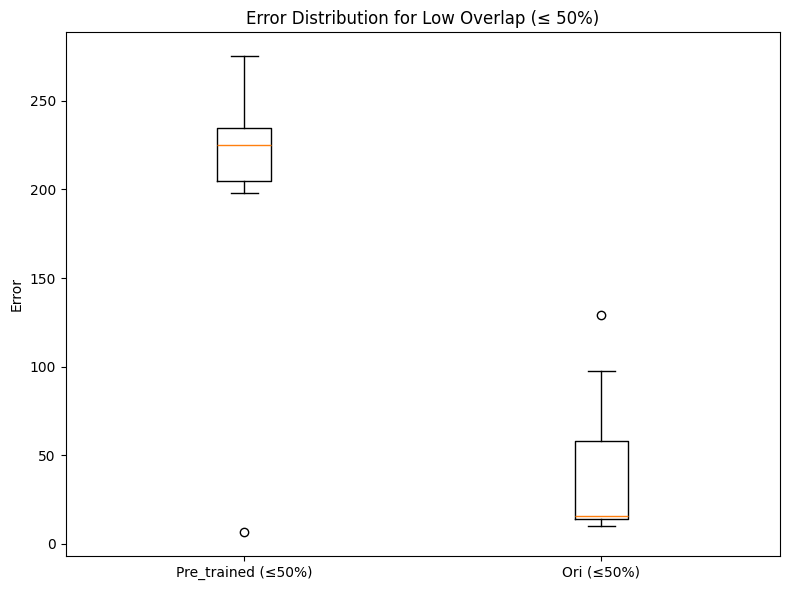

/tmp/ipykernel_15269/1594585607.py:212: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df.loc[high_mask, err_Pre_trained].dropna().values, df.loc[high_mask, err_Ori].dropna().values], labels=["Pre_trained (>50%)", "Ori (>50%)"])


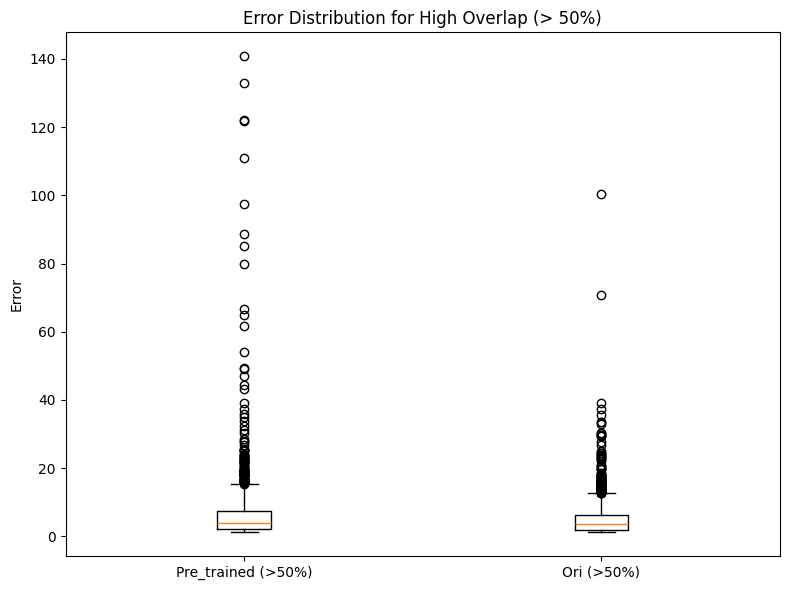

=== Significance Tests (paired) ===
Overall paired t-test: t=5.4789, p=5.0088e-08
Overall Wilcoxon signed-rank: W=146875.5000, p=1.0900e-132
Low overlap (≤50%) paired t-test: t=4.5487, p=3.8971e-03
Low overlap (≤50%) Wilcoxon: W=1.0000, p=3.1250e-02
High overlap (>50%) paired t-test: t=6.3816, p=2.3302e-10
High overlap (>50%) Wilcoxon: W=145434.5000, p=4.1052e-132


In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# 1) Load and prepare data
# -----------------------------
# Adjust the file paths if needed

path_Ori = "/home/chhaileng/Documents/test_model/glue-factory/Output_error/white/matching_results_all_Ori.csv"
path_Pre_trained = "/home/chhaileng/Documents/test_model/glue-factory/Output_error/white/matching_results_all_Pt.csv"

# Load raw
_raw_Pre_trained = pd.read_csv(path_Pre_trained)
_raw_Ori = pd.read_csv(path_Ori)

# Map your actual columns to the names this script expects:
#   id1, id2, overlap (0..1), err_mean
def prepare(df):
    # Try to be robust to minor header differences
    col_id1 = "id1"
    col_id2 = "id2"
    # overlap is stored as "overlap (%)" in your files (0..100). Convert to 0..1.
    if "overlap (%)" in df.columns:
        overlap = df["overlap (%)"].astype(float) / 100.0
    elif "overlap" in df.columns:
        # If already 0..1, keep; if 0..100, convert:
        tmp = pd.to_numeric(df["overlap"], errors="coerce")
        overlap = tmp.where(tmp <= 1.0, tmp / 100.0)
    else:
        raise KeyError("Could not find overlap column (expected 'overlap (%)' or 'overlap').")

    # Use the uv1→uv2 mean error as the metric to compare (fits your earlier structure)
    # If your header uses a different exact spelling, add more fallbacks here
    if "mean_error uv1=uv2 (px)" in df.columns:
        err_mean = pd.to_numeric(df["mean_error uv1=uv2 (px)"], errors="coerce")
    elif "err_mean" in df.columns:
        err_mean = pd.to_numeric(df["err_mean"], errors="coerce")
    else:
        # last resort: try a few common variations
        candidates = [c for c in df.columns if "mean" in c.lower() and "uv1" in c.lower() and ("uv2" in c.lower())]
        if not candidates:
            raise KeyError("Could not find mean error column (e.g., 'mean_error uv1=uv2 (px)').")
        err_mean = pd.to_numeric(df[candidates[0]], errors="coerce")

    out = pd.DataFrame({
        "id1": df[col_id1].astype(int),
        "id2": df[col_id2].astype(int),
        "overlap": overlap,      # 0..1 here
        "err_mean": err_mean
    })
    return out

df_Pre_trained = prepare(_raw_Pre_trained)
df_Ori = prepare(_raw_Ori)

# Merge datasets on pair identifiers
df = df_Pre_trained.merge(df_Ori, on=["id1", "id2"], suffixes=("_Pre_trained", "_Ori"))

# Build a single overlap percentage column (average the two, just in case)
ov_Pre_trained = df["overlap_Pre_trained"] if "overlap_Pre_trained" in df.columns else df["overlap"]
ov_Ori = df["overlap_Ori"] if "overlap_Ori" in df.columns else df["overlap"]
df["overlap_percent"] = ((ov_Pre_trained + ov_Ori) / 2.0) * 100

# Core metrics (errors). If you want median-based comparisons, you can swap in err_median columns similarly.
err_Pre_trained = "err_mean_Pre_trained"
err_Ori = "err_mean_Ori"

# -----------------------------
# Summary tables
# -----------------------------
# Overall summary (mean, median, std, count)
overall_summary = pd.DataFrame({
    "Metric": ["Mean", "Median", "Std", "Count"],
    "Pre_trained": [
        df[err_Pre_trained].mean(),
        df[err_Pre_trained].median(),
        df[err_Pre_trained].std(),
        df[err_Pre_trained].count()
    ],
    "Ori": [
        df[err_Ori].mean(),
        df[err_Ori].median(),
        df[err_Ori].std(),
        df[err_Ori].count()
    ]
})

#  Stress-hold split ( <50%, =50%, >50% )
def categorize_overlap_exact50(x):
    if x < 50:
        return "< 50%"
    elif x == 50:
        return "50%"
    else:
        return "> 50%"

df["OverlapZone"] = df["overlap_percent"].apply(categorize_overlap_exact50)

stress_table = (
    df.groupby("OverlapZone", observed=True)
      .agg(
          MeanError_Pre_trained=(err_Pre_trained, "mean"),
          StdError_Pre_trained=(err_Pre_trained, "std"),
          MeanError_Ori=(err_Ori, "mean"),
          StdError_Ori=(err_Ori, "std"),
          Count=("OverlapZone", "count")
      )
      .reset_index()
)

# % improvement of Ori over Pre_trained: positive means Ori has lower (better) error
stress_table["Improvement_% (Ori vs Pre_trained)"] = (stress_table["MeanError_Pre_trained"] - stress_table["MeanError_Ori"]) / stress_table["MeanError_Pre_trained"] * 100

#  Per 10% overlap bin summary
bins = np.linspace(0, 100, 11)  # 0,10,20,...,100
labels = [f"{int(bins[i])}-{int(bins[i+1])}%" for i in range(len(bins)-1)]
df["OverlapBin"] = pd.cut(
    df["overlap_percent"],
    bins=bins,
    labels=labels,
    right=True,          # (a, b]
    include_lowest=True  # include 0
)

bin_stats = (
    df.groupby("OverlapBin", observed=True)
      .agg(
          MeanError_Pre_trained=(err_Pre_trained, "mean"),
          StdError_Pre_trained=(err_Pre_trained, "std"),
          MeanError_Ori=(err_Ori, "mean"),
          StdError_Ori=(err_Ori, "std"),
          Count=("OverlapBin", "count")
      )
      .reset_index()
)

# Keep bin order stable
bin_stats["OverlapBin"] = pd.Categorical(bin_stats["OverlapBin"], categories=labels, ordered=True)
bin_stats = bin_stats.sort_values("OverlapBin")

# % improvement per bin
bin_stats["Improvement_% (Ori vs Pre_trained)"] = (bin_stats["MeanError_Pre_trained"] - bin_stats["MeanError_Ori"]) / bin_stats["MeanError_Pre_trained"] * 100

# Display tables
print("=== Overall Summary (err_mean) ===")
display(overall_summary)

print("=== Stress-hold ( <50% | 50% | >50% ) ===")
display(stress_table)

print("=== Per 10% Overlap Bin Summary ===")
display(bin_stats)

# Optional: save summaries
# overall_summary.to_csv("overall_summary.csv", index=False)
# stress_table.to_csv("stress_hold_summary.csv", index=False)
# bin_stats.to_csv("bin_summary_10pct.csv", index=False)

# -----------------------------
#  Plots
# -----------------------------
# Trend: Mean error vs overlap bin (with error bars)
plt.figure(figsize=(11, 6))
plt.errorbar(bin_stats["OverlapBin"], bin_stats["MeanError_Pre_trained"], yerr=bin_stats["StdError_Pre_trained"], marker='o', capsize=4, label="Pre_trained")
plt.errorbar(bin_stats["OverlapBin"], bin_stats["MeanError_Ori"], yerr=bin_stats["StdError_Ori"], marker='o', capsize=4, label="Ori")
plt.title("Mean Error ±1 Std vs Overlap Range (10% bins)")
plt.xlabel("Overlap Range (%)")
plt.ylabel("Mean Error")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#  Bar chart: % improvement per bin (Ori vs Pre_trained)
plt.figure(figsize=(11, 6))
plt.bar(bin_stats["OverlapBin"].astype(str), bin_stats["Improvement_% (Ori vs Pre_trained)"])
plt.title("Improvement of Ori over Pre_trained by Overlap Range (10% bins)")
plt.xlabel("Overlap Range (%)")
plt.ylabel("Improvement (%)   [Positive = Ori lower error]")
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

#  Boxplot: overall distribution of errors
plt.figure(figsize=(8, 6))
plt.boxplot([df[err_Pre_trained].dropna().values, df[err_Ori].dropna().values], labels=["Pre_trained", "Ori"])
plt.title("Overall Error Distribution")
plt.ylabel("Error")
plt.tight_layout()
plt.show()

#  Boxplots by overlap zone (low vs high)
low_mask = df["overlap_percent"] <= 50
high_mask = df["overlap_percent"] > 50

# Low (<= 50%)
plt.figure(figsize=(8, 6))
plt.boxplot([df.loc[low_mask, err_Pre_trained].dropna().values, df.loc[low_mask, err_Ori].dropna().values], labels=["Pre_trained (≤50%)", "Ori (≤50%)"])
plt.title("Error Distribution for Low Overlap (≤ 50%)")
plt.ylabel("Error")
plt.tight_layout()
plt.show()

# High (> 50%)
plt.figure(figsize=(8, 6))
plt.boxplot([df.loc[high_mask, err_Pre_trained].dropna().values, df.loc[high_mask, err_Ori].dropna().values], labels=["Pre_trained (>50%)", "Ori (>50%)"])
plt.title("Error Distribution for High Overlap (> 50%)")
plt.ylabel("Error")
plt.tight_layout()
plt.show()

# -----------------------------
#  Significance tests (optional)
# -----------------------------
print("=== Significance Tests (paired) ===")
try:
    from scipy import stats

    # Overall paired tests (same image pairs)
    valid_overall = df[[err_Pre_trained, err_Ori]].dropna()
    t_stat, t_p = stats.ttest_rel(valid_overall[err_Pre_trained], valid_overall[err_Ori])
    w_stat, w_p = stats.wilcoxon(valid_overall[err_Pre_trained], valid_overall[err_Ori])

    print(f"Overall paired t-test: t={t_stat:.4f}, p={t_p:.4e}")
    print(f"Overall Wilcoxon signed-rank: W={w_stat:.4f}, p={w_p:.4e}")

    # Low overlap (<=50%)
    valid_low = df.loc[low_mask, [err_Pre_trained, err_Ori]].dropna()
    if len(valid_low) > 1:
        t_stat, t_p = stats.ttest_rel(valid_low[err_Pre_trained], valid_low[err_Ori])
        w_stat, w_p = stats.wilcoxon(valid_low[err_Pre_trained], valid_low[err_Ori])
        print(f"Low overlap (≤50%) paired t-test: t={t_stat:.4f}, p={t_p:.4e}")
        print(f"Low overlap (≤50%) Wilcoxon: W={w_stat:.4f}, p={w_p:.4e}")
    else:
        print("Low overlap (≤50%): not enough paired samples for test.")

    # High overlap (>50%)
    valid_high = df.loc[high_mask, [err_Pre_trained, err_Ori]].dropna()
    if len(valid_high) > 1:
        t_stat, t_p = stats.ttest_rel(valid_high[err_Pre_trained], valid_high[err_Ori])
        w_stat, w_p = stats.wilcoxon(valid_high[err_Pre_trained], valid_high[err_Ori])
        print(f"High overlap (>50%) paired t-test: t={t_stat:.4f}, p={t_p:.4e}")
        print(f"High overlap (>50%) Wilcoxon: W={w_stat:.4f}, p={w_p:.4e}")
    else:
        print("High overlap (>50%): not enough paired samples for test.")
except Exception as e:
    print("Significance tests skipped (scipy not available or other issue):", e)
